<h2> Data loding and importing needed packages </h2>

<h5> Using keras and for modeling section & sklearn for SVM implementation </h5>
<p> Features extracted with CNN implemented systems (mobileNet) will be used as our input vectors to the SVM-Classifier </p>

In [1]:
import pandas as pd
import numpy as np 
from numpy import expand_dims
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
import PIL


from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential



In [2]:
batch_size = 32
img_height = 511
img_width = 511

In [3]:
from numpy import float16


root = 'Grapevine_Leaves_Image_Dataset'
pics = []
labels = []

for dir, path in zip(os.scandir(root), os.listdir(root)): 
    pics_path = os.listdir(dir)
    for j in pics_path: 
        pics.append(root + '/' + path + '/' + j)
        labels.append(path)


data = []
for i in pics: 
    img = PIL.Image.open(i).convert('RGB')
    data.append(np.array(img))
data = np.array(data).astype(float16)
print('The Shape Of The Data Is: ', data.shape)

The Shape Of The Data Is:  (500, 511, 511, 3)


<h2> Test-Train Split </h2> 

<p> 80-20 split is chosen and we'll have 80 * 4(Data Augmenting) items for each catagory </p>

In [4]:
label_dict = {'Ak': 1, 'Ala_Idris': 2, 'Buzgulu': 3, 'Dimnit': 4, 'Nazli':5}
label_dict_reverse = {y: x for x, y in label_dict.items()}

for i in range(len(labels)): 
    labels[i] = label_dict[labels[i]]


X_train, X_test, y_train, y_test = train_test_split(
                                   data, labels, test_size=0.2, random_state=0)
                                   
X_train = np.array(X_train).astype('uint8')
X_test = np.array(X_test).astype('uint8')
y_train = np.array(y_train).astype('uint8')
y_test = np.array(y_test).astype('uint8')

<h2> Data Augmentation </h2>

<p> we will be using horizontal and vertical flips, rotations, and zoom range of 0.75 to 1.25 </p>
<p> the size of our training data will be changed accordingly, we'll generate 3 more pictures of every picture </p>

In [48]:
print('Size Before Augmentation')
print(X_train.shape, y_train.shape)

Size Before Augmentation
(400, 511, 511, 3) (400,)


In [49]:
datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=90, zoom_range=[0.7, 1.25])
it = datagen.flow(X_train, y=y_train, batch_size=1)

for i in range(len(X_train)*3):
    p, l = it.next()
    X_train = np.concatenate((X_train, p), axis=0)
    y_train = np.concatenate((y_train, l), axis=0)



In [50]:
print('Size After Augmentation')
print(X_train.shape, y_train.shape)

Size After Augmentation
(1600, 511, 511, 3) (1600,)


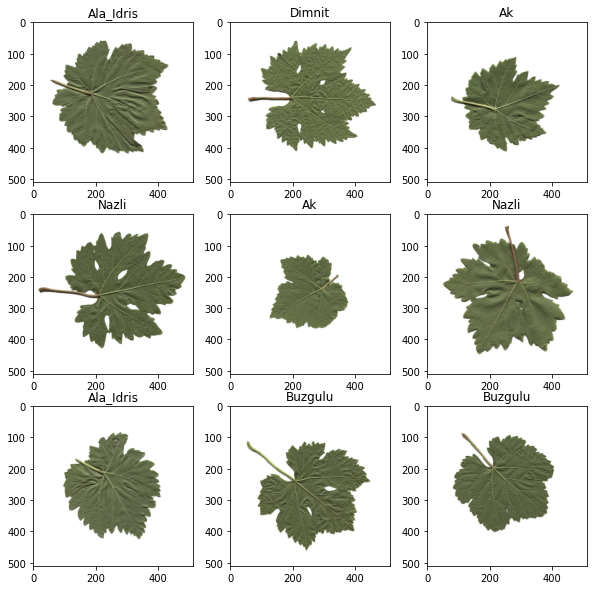

In [51]:
plt.figure(figsize=(10, 10))
for i in range(9):
	plt.subplot(330 + 1 + i)
	image = X_train[i].astype('uint8')
	plt.title(label_dict_reverse[int(y_train[i])])
	plt.imshow(image)
plt.show()

In [52]:
# plt.figure(figsize=(10, 10))
# for i in range(9):
# 	plt.subplot(330 + 1 + i)
# 	batch, label = it.next()
# 	image = batch[0].astype('uint8')
# 	plt.title(label_dict_reverse[int(label)])
# 	plt.imshow(image)
# plt.show()

<h3> Feature Extraction Using CNN

<h3> we will start by preprocessing our data </h3>
we need to resize our data so that it will fit the MobileNetV2 input dimensions

In [5]:
def preprocessing(image, label):
  #image /= 255.0
  img = tf.image.resize(image, [224,224])
  return img, tf.one_hot(label, 5)

X_train_resized, y_train_resized = preprocessing(X_train, y_train)
X_train_resized.shape

TensorShape([400, 224, 224, 3])

Text(0.5, 1.0, 'An Example Of Resized Samples (511 => 224)')

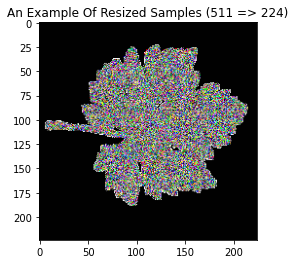

In [54]:
plt.imshow(np.array(X_train_resized[3]*255).astype('uint8'))
plt.title('An Example Of Resized Samples (511 => 224)')

<h3>Loading the MobileNetV2 Model from tensorflow_hub

In [ ]:
from sklearn import metrics
import tensorflow_hub as hub

mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

mobile_net_layers = hub.KerasLayer(mobilenet_v2, input_shape=(224, 224, 3))
mobile_net_layers.trainable = False

neural_net = tf.keras.Sequential([
  mobile_net_layers,
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(5, activation='softmax')
])
neural_net.summary()



neural_net.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=['accuracy'])


model_fit = neural_net.fit(x=X_train_resized/255, y=y_train_resized, batch_size=32, epochs=25, validation_split=0.2, )  




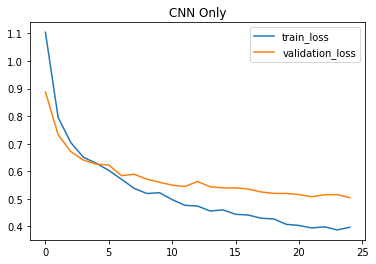

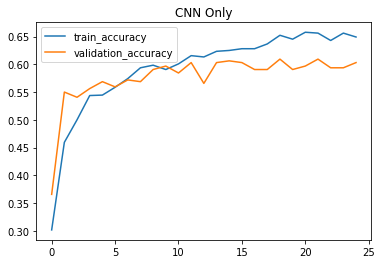

In [ ]:
plt.plot(model_fit.history['loss'], label='train_loss')
plt.plot(model_fit.history['val_loss'],label='validation_loss')
plt.title('CNN Only')
plt.legend()
plt.show()


plt.plot(model_fit.history['accuracy'], label='train_accuracy')
plt.plot(model_fit.history['val_accuracy'],label='validation_accuracy')
plt.title('CNN Only')
plt.legend()

<h4> we will load the model once again but this time, we won't learn it, we'll just extract the features and use them as inputs to SVM machines

In [72]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
from sklearn.utils import shuffle
import tensorflow_hub as hub

mobile_net_layers = hub.KerasLayer(mobilenet_v2, input_shape=(224, 224, 3))
mobile_net_layers.trainable = False

neural_net = tf.keras.Sequential([mobile_net_layers])
neural_net.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=['accuracy'])
features = neural_net.predict(X_train_resized/255)  


50/50 [==============================] - 26s 490ms/step


<h4> SVM machines are by default binary classifiers so solve this issue there two methods sklearn provides us with: ovo (one vs ove) & ovr (one vs rest)

we're going to use ovr and crossvalidate our model using 10 folds, the results are available below

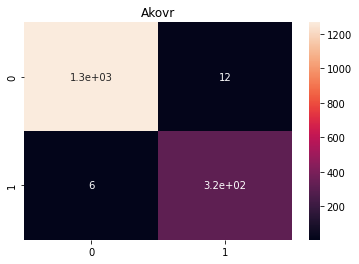

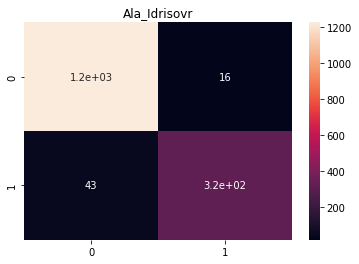

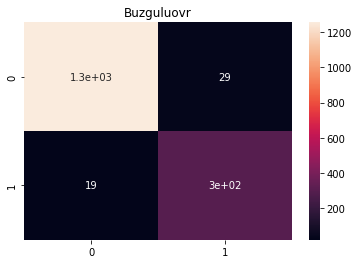

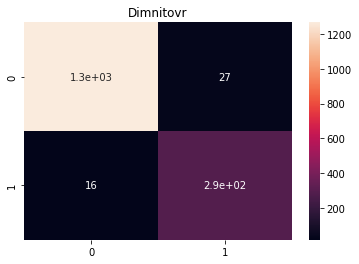

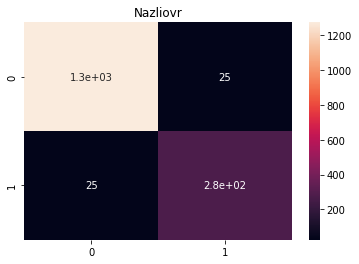

In [83]:
from sklearn import svm
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns 

y_final = []
y_train_resized = np.array(y_train_resized)
for i in range(len(y_train_resized)): 
    y_final.append(y_train_resized[i].argmax())


clf = svm.SVC(decision_function_shape='ovr')
clf.fit(features, np.asarray(y_final))
preds = clf.predict(features)
cm = multilabel_confusion_matrix(preds, np.asarray(y_final))
for i, x in enumerate(cm): 
    sns.heatmap(x, annot=True)
    plt.title(label_dict_reverse[i+1] + 'ovr')
    plt.show()

In [84]:
from sklearn.model_selection import cross_val_score
clf = svm.SVC(decision_function_shape='ovo')
scores = cross_val_score(clf, features, y_final, cv=10, scoring='f1_macro')

print('The Scores of Each CV run is listed below')
CV_scores = pd.DataFrame(scores, columns=['Score'])
pd.DataFrame(CV_scores.Score.round(2))
print('And the mean score of all the runs is: ', end='')
print(sum(scores) / len(scores))

The Scores of Each CV run is listed below
0.9051191765187709 0.8745149090435976 0.8672641898317506 0.9248357931187734 0.8758128783332637 0.8682432723822666 0.894144265232975 0.8809045689019896 0.8686190865662045 0.8691129976580797
And the mean score of all the runs is: 0.8828571137587671


# Auto Encoder

we'll use this model to investigate how denoising could be done using a neural network
we'll create noised images using gaussian methods, then feed the network the noised ones as inputs and clear ones as expected values
the network will learn to denoise the images it has been given, it is implemented by keras API and open-cv for adding noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


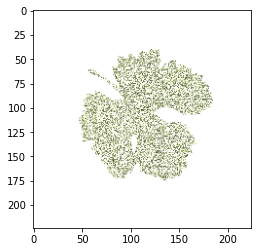

In [6]:
import cv2

def add_gaussian_noise(X_imgs):
    gaussian_noise_imgs = []
    row, col, _ = X_imgs[0].shape
    # Gaussian distribution parameters
    mean = 0
    var = 0.1
    sigma = var ** 0.5
    
    for X_img in X_imgs:
        X_img = X_img/255
        #gaussian = np.random.normal(mean,sigma,(row,col, 1))
        gaussian = np.random.random((row, col, 1)).astype(np.float32)
        gaussian = np.concatenate((gaussian, gaussian, gaussian), axis = 2)
        gaussian_img = X_img + gaussian
        gaussian_noise_imgs.append(gaussian_img)
    gaussian_noise_imgs = np.array(gaussian_noise_imgs, dtype = np.float32)
    return gaussian_noise_imgs


X_train_noisy = add_gaussian_noise(X_train_resized)
plt.imshow(X_train_noisy[10])

In [7]:
X_train_resized.shape

TensorShape([400, 224, 224, 3])

In [9]:
np.array(X_train_noisy).shape

(400, 224, 224, 3)

In [16]:
input_img = keras.Input(shape=(224, 224, 3))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mae')

autoencoder.fit(x=X_train_noisy, y=np.array(X_train_resized/255),
                epochs=5,
                batch_size=32,
                shuffle=False,
                validation_split=0.2)


Epoch 1/5
10/10 [==============================] - 22s 2s/step - loss: 0.2785 - val_loss: 0.2041
Epoch 2/5
10/10 [==============================] - 21s 2s/step - loss: 0.2073 - val_loss: 0.2041
Epoch 3/5
10/10 [==============================] - 19s 2s/step - loss: 0.2071 - val_loss: 0.2041
Epoch 4/5
10/10 [==============================] - 19s 2s/step - loss: 0.2071 - val_loss: 0.2041
Epoch 5/5
10/10 [==============================] - 20s 2s/step - loss: 0.2071 - val_loss: 0.2041


In [17]:
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 56, 56, 32)        9248

In [28]:
X_train_noisy[1].shape

(224, 224, 3)